In [1]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

#import torch_xla
#import torch_xla.core.xla_model as xm

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

import lightgbm as lgb

random.seed(2020)
np.random.seed(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X

In [3]:
def make_offdf(train_df, original_test_df, feature, params_list, _type):
    k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
    
    y_1 = train_df.jobflag.apply(lambda x: 1 if x==1 else 0)
    y_2 = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
    y_3 = train_df.jobflag.apply(lambda x: 1 if x==3 else 0)
    y_4 = train_df.jobflag.apply(lambda x: 1 if x==4 else 0)
    
    off_df = []
    test_df = original_test_df.copy()
    for i in range(4):
        test_df[f'lgb_preds_{i+1}_{_type}']=0
    
    for trn, val in k.split(train_df, train_df.jobflag):
        train_X, val_X = train_df.iloc[trn,:][feature], train_df.iloc[val,:][feature]
        tmp_off_df = train_df.iloc[val,:]
        c=1
        for y, param in zip([y_1, y_2, y_3, y_4], params_list):
            tmp_off_df[f'lgb_preds_{c}_{_type}']=0
            for _ in range(5):
                train_y, val_y = y.iloc[trn], y.iloc[val]
                train_set= lgb.Dataset(train_X,  train_y)
                val_set = lgb.Dataset(val_X,  val_y)   

                model = lgb.train(
                    train_set=train_set, valid_sets=[train_set, val_set], params=param, num_boost_round=3000, 
                    early_stopping_rounds=200, verbose_eval=500
                )
                tmp_off_df[f'lgb_preds_{c}_{_type}'] += model.predict(val_X)/5
                param['random_state']+=1
                
                test_df[f'lgb_preds_{c}_{_type}'] += model.predict(test_df[feature])/5
                
            c+=1
        
        off_df.append(tmp_off_df)
    
    for i in range(4):
        test_df[f'lgb_preds_{i+1}_{_type}']/=5
    
    off_df = pd.concat(off_df, axis=0)
    off_df.sort_values('text_id', inplace=True)
    return off_df.reset_index(drop=True), test_df

In [4]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.X)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        # argumentation
        x = torch.FloatTensor(self.X[index])
        if self.y!=None:
            return {
                'input': x,
                'label': torch.FloatTensor(self.y[index])
            }
        else:
            return {
                'input': x
            }
        
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / np.sqrt(label_to_count[self._get_label(dataset, idx)])
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        """if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError"""
        return dataset.y[idx][0]
        
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
    
class MLPClass(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_size, 300),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 100),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, output_size)
        )
        
            
        
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.fc(x)
        #x= self.sigmoid(x)
        x= self.softmax(x)
        return x

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_1 = pred[target<1.5][:,0]
        loss_1 = torch.mean((pred_1-1)**2)
        
        pred_2 = pred[(target>1.5)&(target<2.5)][:,1]
        loss_2 = torch.mean((pred_2-1)**2)
        
        pred_3 = pred[(target>2.5)&(target<3.5)][:,2]
        loss_3 = torch.mean((pred_3-1)**2)

        pred_4 = pred[target>3.5][:,3]
        loss_4 = torch.mean((pred_4-1)**2)
        
        loss = loss_1 + loss_2 + loss_3 + loss_4
        
        return loss
    
class Model_Trainer:
    def __init__(self, output_size, feature):
        self.device =  'cuda' if cuda.is_available() else 'cpu'
        self.model = MLPClass(len(feature), output_size).to(self.device)
        self.criterion = CustomLoss()
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=6e-4, weight_decay=0.0005)
        self.scheduler = CosineAnnealingLR(optimizer=self.optimizer, T_max=10)
        self.output_size = output_size

    
    def load_params(self, state_dict):
        self.model.load_state_dict(state_dict)

    
    def train(self, trn_dataloader):
        self.model.train()
        avg_loss=0
        for data in trn_dataloader:
            self.optimizer.zero_grad()
            x = data['input'].to(self.device)
            label = data['label'].squeeze(1)
            if len(np.unique(label))!=4:
                continue
            label = label.to(self.device)
            x = self.model(x)   
            loss = self.criterion(x, label)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            avg_loss += loss.item()/len(trn_dataloader)
            
        return avg_loss

    def eval(self, val_dataloader):
        self.model.eval()
        avg_loss=0
        for data in val_dataloader:
            x = data['input'].to(self.device)
            label = data['label'].to(self.device).squeeze(1)
            x = self.model(x)
            loss = self.criterion(x, label)
            avg_loss += loss.item()/len(val_dataloader)
        return avg_loss, x.detach().cpu().numpy()

    def predict(self, data_loader):
        self.model.eval()
        for data in data_loader:
            x = data['input'].to(self.device)
            x = self.model(x)
        return x.detach().cpu().numpy()
    
def make_off_df(train_df, feature):
    k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
    #k = KFold(n_splits=5, random_state=202, shuffle=True)
    
    trn_cv_loss = []
    val_cv_loss = []
    off_df=[]
    
    fake_label =  train_df.jobflag.apply(
        lambda x: random.randint(1,4)
    )
    for trn, val in k.split(train_df, train_df.jobflag):
    #for trn, val in k.split(train_df, fake_label):
    #for trn, val in k.split(train_df):
        trn_df = train_df.iloc[
            trn,:
        ]
        val_df = train_df.iloc[
            val,:
        ]
        
        """sns.distplot(trn_df['jobflag'])
        sns.distplot(val_df['jobflag'])
        plt.show()
        """
        trn_X, trn_y = trn_df[feature].values.tolist(),trn_df[['jobflag']].values.tolist() 
        val_X, val_y = val_df[feature].values.tolist(),val_df[['jobflag']].values.tolist() 


        trn_data_set = CreateDataset(trn_X, trn_y)
        val_data_set = CreateDataset(val_X, val_y)
        trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=256*2, sampler=ImbalancedDatasetSampler(trn_data_set))
        val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))

    

        trn_loss_list=[]
        val_loss_list=[]

        model_trainer = Model_Trainer(4, feature)
        
        for e in tqdm(range(40)):
            trn_loss_avg = model_trainer.train(trn_dataloader)
            val_loss_avg, p = model_trainer.eval(val_dataloader)
            for mm in range(4):
                val_df[f'p_{mm+1}_{e}'] = p[:,mm]
            val_df[f'p_{e}'] = np.argmax(p, axis=1)+1

            trn_loss_list.append(trn_loss_avg)
            val_loss_list.append(val_loss_avg)

        trn_cv_loss.append(trn_loss_list)
        val_cv_loss.append(val_loss_list)
        off_df.append(val_df)
        
    off_df = pd.concat(off_df, axis=0)
    off_df.sort_values('text_id', inplace=True)
    off_df.reset_index(drop=True, inplace=True)
    return off_df, trn_cv_loss, val_cv_loss

def predict_test_df(train_df, test_df, feature):

    X, y = train_df[feature].values.tolist(),train_df[['jobflag']].values.tolist()
    trn_data_set = CreateDataset(X, y)
    trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=256*2, sampler=ImbalancedDatasetSampler(trn_data_set))
    
    val_X, val_y = test_df[feature].values.tolist(), None
    val_data_set = CreateDataset(val_X, val_y)
    val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))
    
    trn_loss_list=[]
    model_trainer = Model_Trainer(4, feature)
    
    for e in tqdm(range(40)):
        trn_loss_avg = model_trainer.train(trn_dataloader)
        p = model_trainer.predict(val_dataloader)
        for mm in range(4):
            test_df[f'p_{mm+1}_{e}'] = p[:,mm]
        test_df[f'p_{e}'] = np.argmax(p, axis=1)+1
        
        trn_loss_list.append(trn_loss_avg)
        
    return test_df, trn_loss_list

In [5]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
for i in range(4):    
    train_df = pd.merge(train_df, pd.read_csv(f'../train_df_off{i+1}.csv'), on='id')
    test_df = pd.merge(test_df, pd.read_csv(f'../test_df_off{i+1}.csv').drop(columns=['description', 'jobflag']), on='id')
df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
df['text_id'] = df['id']
del df['id']
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

cols = ['jobflag','text_id']
X = preprocessing.vectorize_tfidf(df)
X = pd.concat([df[cols], X], axis=1)

In [6]:
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

mlp_feature = train_df.drop(columns=cols).columns.tolist()

off_df_mlp, trn_cv_loss, val_cv_loss = make_off_df(train_df, mlp_feature)
test_df_mlp, trn_loss_list = predict_test_df(train_df, test_df, mlp_feature)

In [7]:
mlp_pred_cols = [f'p_{mm+1}_{e}' for e in range(40) for mm in range(4)]

In [8]:
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

train_df2 = pd.concat([
    train_df,
    off_df_mlp[mlp_pred_cols]
], axis=1)

test_df2 = pd.concat([
    test_df,
    test_df_mlp[mlp_pred_cols]
], axis=1)

In [9]:
train_df2.shape, test_df2.shape

((2886, 3545), (1743, 3544))

In [10]:
[col for col in train_df2.columns if col not in test_df2.columns]

['jobflag']

In [11]:
test_df2.shape, train_df2.shape, train_df.shape

((1743, 3544), (2886, 3545), (2886, 3385))

In [12]:
mlp_feature2 = train_df2.drop(columns=cols).columns.tolist()

In [13]:
off_df_mlp2, trn_cv_loss2, val_cv_loss2 = make_off_df(train_df2, mlp_feature2)
test_df_mlp2, trn_loss_list2 = predict_test_df(train_df2, test_df2, mlp_feature2)

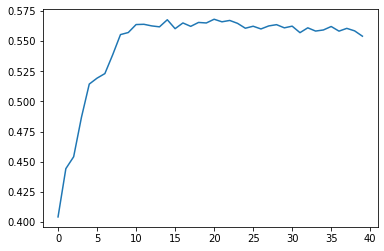

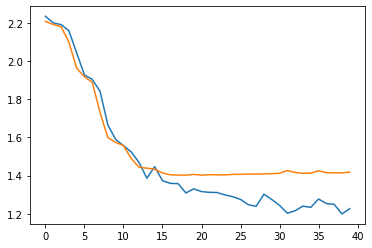

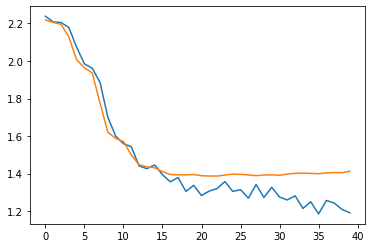

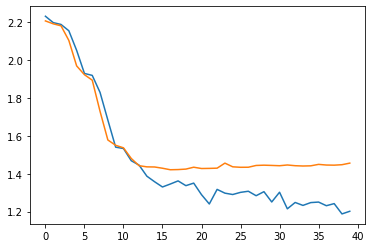

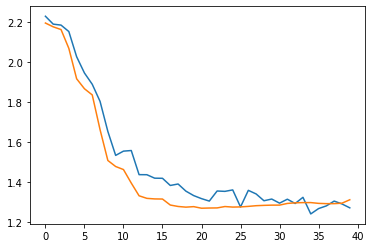

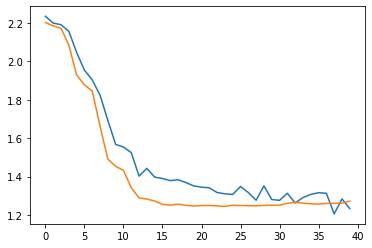

In [14]:
scores=[]
for i in range(40):   
    p = off_df_mlp2[f'p_{i}']
    label = off_df_mlp2['jobflag']
    score = metrics.f1_score(label, p, average='macro')
    scores.append(score)
plt.plot(scores)
plt.show()

for i in range(len(trn_cv_loss)):
    plt.plot(trn_cv_loss2[i])
    
    plt.plot(val_cv_loss2[i])
    plt.show()

In [15]:
data = pd.DataFrame()
data['score'] = scores
data.max()

score    0.568081
dtype: float64

In [89]:
test_df_mlp2.columns

Index(['text_id', '000', '10', '10g', '11', '12', '12c', '150', '20', '2003',
       ...
       'p_30', 'p_31', 'p_32', 'p_33', 'p_34', 'p_35', 'p_36', 'p_37', 'p_38',
       'p_39'],
      dtype='object', length=3588)

In [16]:
preds = np.zeros((len(test_df), 4))
for i in range(8, 15):
    preds += test_df_mlp2[[f'p_{label+1}_{i}'  for label in range(4)]].values

In [17]:
test_df_mlp2['final_preds'] = 1+np.argmax(preds, axis=1)

In [20]:
test_df_mlp2[['text_id', 'final_preds']].to_csv('/Users/abcdm/Downloads/sub_17.csv', index=False, header=False)

In [21]:
data = pd.merge(
    pd.read_csv('/Users/abcdm/Downloads/sub_17.csv', header=None),
    pd.read_csv('/Users/abcdm/Downloads/sub_14.csv', header=None),
    on=[0]
)

pd.concat([
    pd.get_dummies(data['1_x']).rename(
        columns={i+1:f'{i+1}_16' for i in range(4)}
    ),
    pd.get_dummies(data['1_y']).rename(
        columns={i+1:f'{i+1}_14' for i in range(4)}
    )
], axis=1).corr()

,1_16,2_16,3_16,4_16,1_14,2_14,3_14,4_14
1_16,1.000000,-0.202967,-0.405203,-0.349852,0.576862,0.054272,-0.304100,-0.232561
2_16,-0.202967,1.000000,-0.277931,-0.239965,0.050468,0.403125,-0.087375,-0.205240
3_16,-0.405203,-0.277931,1.000000,-0.479067,-0.315788,-0.141421,0.550995,-0.205464
4_16,-0.349852,-0.239965,-0.479067,1.000000,-0.236045,-0.191365,-0.236724,0.578679
1_14,0.576862,0.050468,-0.315788,-0.236045,1.000000,-0.169278,-0.413635,-0.357691
2_14,0.054272,0.403125,-0.141421,-0.191365,-0.169278,1.000000,-0.246977,-0.213574
3_14,-0.304100,-0.087375,0.550995,-0.236724,-0.413635,-0.246977,1.000000,-0.521874
4_14,-0.232561,-0.205240,-0.205464,0.578679,-0.357691,-0.213574,-0.521874,1.000000


In [22]:
data = pd.merge(
    pd.read_csv('/Users/abcdm/Downloads/sub_17.csv', header=None),
    pd.read_csv('/Users/abcdm/Downloads/sub_15.csv', header=None),
    on=[0]
)

pd.concat([
    pd.get_dummies(data['1_x']).rename(
        columns={i+1:f'{i+1}_16' for i in range(4)}
    ),
    pd.get_dummies(data['1_y']).rename(
        columns={i+1:f'{i+1}_15' for i in range(4)}
    )
], axis=1).corr()

,1_16,2_16,3_16,4_16,1_15,2_15,3_15,4_15
1_16,1.000000,-0.202967,-0.405203,-0.349852,0.812572,-0.087445,-0.376534,-0.281971
2_16,-0.202967,1.000000,-0.277931,-0.239965,-0.080874,0.719331,-0.246293,-0.231100
3_16,-0.405203,-0.277931,1.000000,-0.479067,-0.362670,-0.161158,0.775078,-0.357582
4_16,-0.349852,-0.239965,-0.479067,1.000000,-0.309603,-0.267461,-0.291449,0.803064
1_15,0.812572,-0.080874,-0.362670,-0.309603,1.000000,-0.221800,-0.388875,-0.335892
2_15,-0.087445,0.719331,-0.161158,-0.267461,-0.221800,1.000000,-0.303224,-0.261910
3_15,-0.376534,-0.246293,0.775078,-0.291449,-0.388875,-0.303224,1.000000,-0.459200
4_15,-0.281971,-0.231100,-0.357582,0.803064,-0.335892,-0.261910,-0.459200,1.000000
